# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Описание признаков:**
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

**План работы**
1. Загрузка и предобработка данных.
2. Обучение различных моделей:
- LogisticRegression;
- DecisionTreeClassifier;
- Random Forest;
3. Выбор наилучшей модели.
4. Анализ влияния различных параметров на результат.
5. Выполнение прогноза для тестовой выборки.
6. Подсчет прибыли;
7. Описание портрета «ненадёжного» клиента.

In [1]:
import warnings

import seaborn as sns
import pandas as pd
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
parametrs_tree = {
    "max_depth": np.arange(10, 20, 2),
    'min_samples_leaf': np.arange(1, 8, 1),
    'min_samples_split': np.arange(2, 10, 2),
    "class_weight": ["balanced"]
}
parametrs_logistic = {
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "class_weight": ["balanced"]
}
parametrs_forest = {
    "n_estimators": np.arange(160, 210, 100),
    "max_depth": np.arange(9, 12, 1),
    'min_samples_leaf': np.arange(3, 6, 1),
    'min_samples_split': np.arange(1, 4, 1),
    "class_weight": ["balanced"]
}

Введем константы

In [3]:
ROOM_COST = pd.DataFrame(data={'per_night': [1000, 800, 600, 550, 500, 450, 350],
                               'once_service': [400, 350, 350, 150, 150, 150, 150]},
                         index=[1, 2, 3, 4, 5, 6, 7])
BUDGET = 400000
OFF_SEASON_COEF = 1.2
SUMMER_COEF = 1.4
OFF_SEASON = [3, 4, 5, 9, 10, 11]
SUMMER = [6, 7, 8]

# Открываем файл с данными

In [4]:
df = pd.read_csv('hotel_train.csv')

# Предобработка и исследовательский анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
print(f"Количество дубликатов {df.duplicated().sum()}")
print(f"Количество пропусков {df.isna().sum().sum()}")

Количество дубликатов 0
Количество пропусков 0


**Ошибочных типов, дубликатов и пропусков в базе данных не обнаружилось.**

In [7]:
for index in range(1, 25):
    if not df.iloc[:, index].dtypes == np.object_:
        z_count = np.abs(stats.zscore(df.iloc[:, index])) > 3
        if z_count.sum() > 0:
            print(df.iloc[:, index].name, z_count.sum())

stays_in_weekend_nights 152
adults 179
children 1352
babies 452
is_repeated_guest 1771
previous_cancellations 166
previous_bookings_not_canceled 396
booking_changes 2419
days_in_waiting_list 1383
required_car_parking_spaces 3682
total_of_special_requests 1156
total_nights 270


Воспользовавшись z - оценкой вывели количество выбросов для каждого столбца. Для задач машинного обучения данные в выборке не должны содержать выбросов и быть максимально стандартизированы, так что единичные предельные значения необходимо удалить.

In [8]:
for index in range(1, 25):
    if not df.iloc[:, index].dtypes == np.object_:
        z_boolean = np.abs(stats.zscore(df.iloc[:, index])) < 3
        df = df[z_boolean]
len(df)

53902

Удалилось в общем 11327 выбросов по всем данным, это приблезительно 17% от начальных данных.

Удалим id записи не пригодиться в далнейшей работе.

In [9]:
df = df.drop('id', axis = 1)
df = df.reset_index(drop = True)

Перепишем индексы

In [10]:
iso_countries = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 
'AND', 'AGO', 'AIA', 'ATA', 'ATG', 
'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 
'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 
'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 
'BTN', 'BOL', 'BES', 'BIH', 'BWA', 
'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 
'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 
'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 
'CHN', 'CXR', 'CCK', 'COL', 'COM', 
'COG', 'COD', 'COK', 'CRI', 'CIV', 
'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 
'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 
'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 
'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 
'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 
'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 
'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 
'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 
'HTI', 'HMD', 'VAT', 'HND', 'HKG', 
'HUN', 'ISL', 'IND', 'IDN', 'IRN', 
'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 
'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 
'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 
'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 
'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 
'LUX', 'MAC', 'MKD', 'MDG', 'MWI', 
'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 
'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 
'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 
'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 
'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 
'NIC', 'NER', 'NGA', 'NIU', 'NFK', 
'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 
'PSE', 'PAN', 'PNG', 'PRY', 'PER', 
'PHL', 'PCN', 'POL', 'PRT', 'PRI', 
'QAT', 'REU', 'ROU', 'RUS', 'RWA', 
'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 
'SPM', 'VCT', 'WSM', 'SMR', 'STP', 
'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 
'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 
'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 
'LKA', 'SDN', 'SUR', 'SJM', 'SWZ', 
'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 
'TZA', 'THA', 'TLS', 'TGO', 'TKL', 
'TON', 'TTO', 'TUN', 'TUR', 'TKM', 
'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 
'GBR', 'USA', 'UMI', 'URY', 'UZB', 
'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 
'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

In [11]:
for i in df['country'].unique():
    if i in iso_countries:
        continue
    else:
        print(i)

CN
TMP


**В странах имеется нестандартнизированный код Китая. Поменяем его на CHN.**

In [12]:
df['country'] = df['country'].replace('CN', 'CHN')

In [13]:
df['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)

In [14]:
df.reserved_room_type.unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [15]:
df.meal.unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)

In [16]:
df['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [17]:
df['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

**Наблюдаются ошибочные пробелы.**

In [18]:
categ_columns = df.select_dtypes(include = 'object').columns
for col in categ_columns:
    df[col] = df[col].str.strip()

## Расмотрим распределения данных.

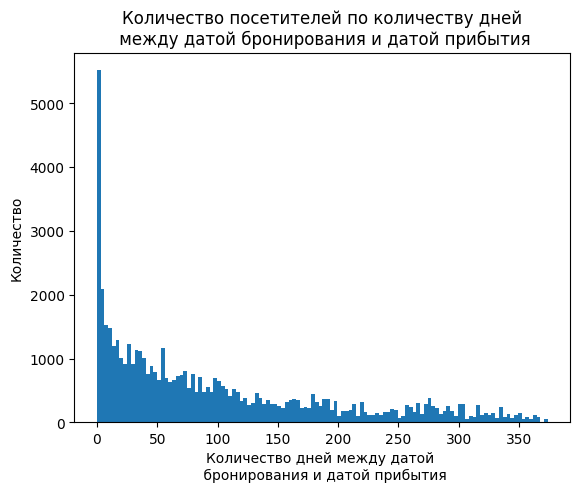

In [19]:
df['lead_time'].plot(kind = 'hist', bins = 120)
plt.title('Количество посетителей по количеству дней\n между датой бронирования и датой прибытия')
plt.xlabel("Количество дней между датой \n бронирования и датой прибытия")
plt.ylabel("Количество");

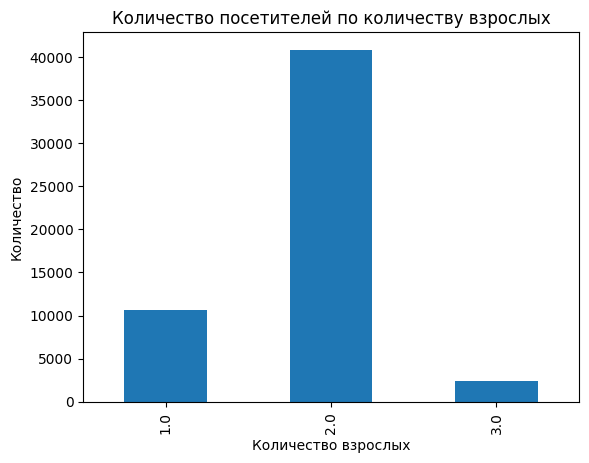

In [20]:
df['adults'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Количество посетителей по количеству взрослых')
plt.xlabel("Количество взрослых")
plt.ylabel("Количество");

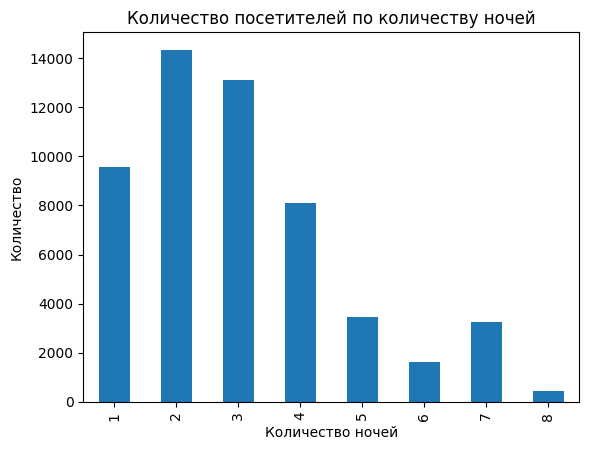

In [21]:
df['total_nights'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Количество посетителей по количеству ночей')
plt.xlabel("Количество ночей")
plt.ylabel("Количество");

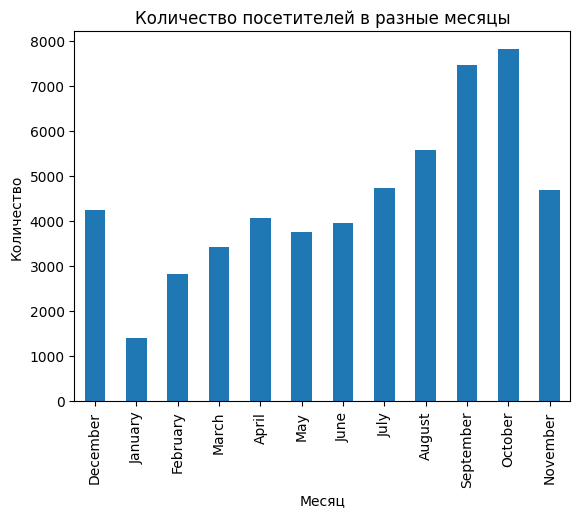

In [22]:
df['arrival_date_month'].value_counts().\
reindex(index = ['December', 'January', 'February',
                 'March', 'April', 'May', 
                 'June', 'July', 'August',
                 'September', 'October', 'November']).plot(kind = 'bar')
plt.title('Количество посетителей в разные месяцы')
plt.xlabel("Месяц")
plt.ylabel("Количество");

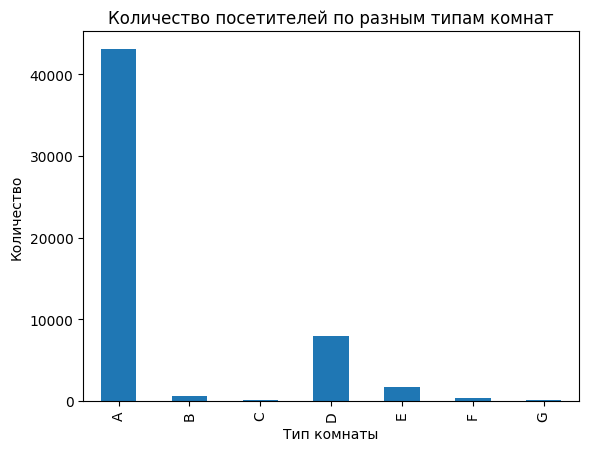

In [23]:
df['reserved_room_type'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Количество посетителей по разным типам комнат')
plt.xlabel("Тип комнаты")
plt.ylabel("Количество");

- **Чаще всего снимают самые дорогие комнаты.**
- **Осенью чаще всего снимают комнаты, меньше всего в Январе.**
- **Чаще всего комната нужна на 2-3 дня.**

In [24]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [25]:
reserved_room_type_dict = {'A': 1, 'C': 2,
                           'D': 3, 'E': 4, 'G': 5, 'F': 6, 'B': 7}
arrival_date_month_dict = {'December':12, 'January':1, 'February':2,
                           'March':3, 'April':4, 'May':5,
                           'June':6, 'July':7, 'August':8,
                           'September':9, 'October':10, 'November':11}

replacing_dict = {'reserved_room_type': reserved_room_type_dict,
                  'arrival_date_month': arrival_date_month_dict}

df = df.replace(replacing_dict)

In [26]:
categ_columns = df.select_dtypes(include = 'object').columns
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(df[categ_columns])
df = pd.concat([pd.DataFrame(encoder.transform(df[categ_columns]).toarray()), df], axis = 1)
df = df.drop(categ_columns, axis = 1)

In [27]:
df.columns = [str(col) for col in df.columns]

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [53]:
def income(row):
    month = row['arrival_date_month']
    room_type = row['reserved_room_type']
    
    season_coef = 1
    if month in SUMMER:
        season_coef = SUMMER_COEF
    elif month in OFF_SEASON:
        season_coef = OFF_SEASON_COEF
    
    once_service = ROOM_COST['once_service'][room_type]
    night_cost = ROOM_COST['per_night'][room_type]
    
    income = 0
    
    if row['is_canceled'] == 1:
        income -= once_service + night_cost * season_coef
    else:
        income -= (np.ceil(row['total_nights'] / 2)) * once_service
        income += row['total_nights'] * night_cost * season_coef
        
    return income

Воспользуюсь функцией после импорта тестовых данных

### Шаг 4. Разработка модели ML

#### Разработка модели ML

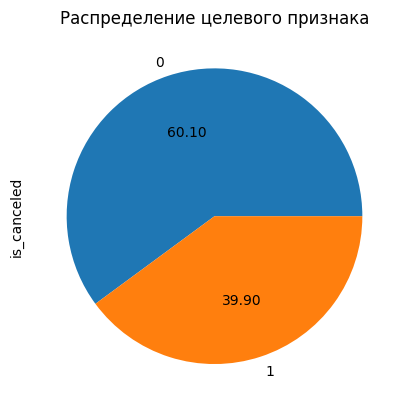

In [29]:
df['is_canceled'].value_counts().plot(kind = "pie", autopct='%.2f')
plt.title("Распределение целевого признака")
plt.xticks(rotation = 0);

Баланс классов приемлемый.

Для подбора гиперпараметров будем использовать AUC-score из-за низкой чувствительности к дисбалансу классов.

Закоментирую подбор, продублировав в markdown самые важные гиперпараметры и лучшую точность.

In [30]:
features = df.drop('is_canceled', axis = 1)
target = df['is_canceled']

In [31]:
# logistic_model = LogisticRegression(random_state = 12345)
# grid = GridSearchCV(logistic_model, parametrs_logistic, cv=5, scoring = 'roc_auc')
# grid.fit(features, target)
# print("Лучшие параметры:", grid.best_params_)
# print("Лучший результат", grid.best_score_)

Лучшие параметры: {'class_weight': 'balanced', 'solver': 'liblinear'}

Лучший результат 0.8341778593822508

In [32]:
# tree_model = DecisionTreeClassifier(random_state = 12345)
# grid = GridSearchCV(tree_model, parametrs_tree, cv=5, scoring = 'roc_auc', verbose=10)
# grid.fit(features, target)
# print("Лучшие параметры:", grid.best_params_)
# print("Лучший результат", grid.best_score_)

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Лучший результат 0.8167774820273312

In [33]:
# forest_model = RandomForestClassifier(random_state = 12345)
# grid = GridSearchCV(forest_model, parametrs_forest, cv=5, scoring = 'roc_auc', verbose=10)
# grid.fit(features, target)
# print("Лучшие параметры:", grid.best_params_)
# print("Лучший результат", grid.best_score_)

Окончательный результат:

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160}

Лучший результат 0.9118000214762719

Лучший результат показала модель рандомного леса. Для теста на тесовой выборке будет использовать эту модель.

In [34]:
model = RandomForestClassifier(random_state = 12345, class_weight = 'balanced',
                                max_depth = 10, min_samples_leaf = 4,
                               min_samples_split = 2, n_estimators = 160)
model.fit(features, target)
predict = model.predict(features)
probabilities = model.predict_proba(features)[:, 1]
f1 = f1_score(target, predict)
roc_auc = roc_auc_score(target, probabilities)
print("F1 score =", f1)
print('ROC-AUC score =', roc_auc)

F1 score = 0.7860175018379302
ROC-AUC score = 0.9102700434164324


Отличные результаты. Точность высокая.

#### Тест на тестовой выборке

In [35]:
df_test = pd.read_csv('hotel_test.csv')

*Проведем предработку данных*

In [36]:
df_test = df_test.drop('id', axis = 1)
for col in categ_columns:
    df_test[col] = df_test[col].str.strip()
df_test = df_test.replace(replacing_dict)
df_test = pd.concat([pd.DataFrame(encoder.transform(df_test[categ_columns]).toarray()), df_test], axis = 1)
df_test = df_test.drop(categ_columns, axis = 1)
df_test.columns = [str(col) for col in df_test.columns]

In [37]:
features_test = df.drop('is_canceled', axis = 1)
target_test = df['is_canceled']


predict = model.predict(features_test)
probabilities = model.predict_proba(features_test)[:, 1]

f1 = f1_score(target_test, predict)
roc_auc = roc_auc_score(target_test, probabilities)

print("F1 score =", f1)
print('ROC-AUC score =', roc_auc)

F1 score = 0.7860175018379302
ROC-AUC score = 0.9102700434164324


Отличный результат: ROC-AUC в 0.91 и f1 в 0.78

Теперь приступим к подсчету прибыли

#### Подсчет прибыли.

In [56]:
def income_with_sys(row): 
    month = row['arrival_date_month']
    room_type = row['reserved_room_type']
    
    season_coef = 1
    if month in SUMMER:
        season_coef = SUMMER_COEF
    elif month in OFF_SEASON:
        season_coef = OFF_SEASON_COEF
    
    once_service = ROOM_COST['once_service'][room_type]
    night_cost = ROOM_COST['per_night'][room_type]
    
    income = 0
    
    if row['predict'] == 0 and row['is_canceled'] == 1:
        income -= once_service + night_cost * season_coef
    elif row['predict'] == 1 and row['is_canceled'] == 1:
        global sys_income, count_sys_work
        sys_income += once_service + night_cost * season_coef
        count_sys_work += 1
        income -= (once_service + night_cost * season_coef) * 0.2
    else: #predict = target = 0 or predict = 1 and target = 0
        income -= (np.ceil(row['total_nights'] / 2)) * once_service
        income += row['total_nights'] * night_cost * season_coef
        
    return income

In [57]:
features_test['predict'] = predict
features_test['is_canceled'] = target_test

features_test['income_witout_system'] = features_test.apply(income, axis = 1)

In [60]:
sys_income = 0
count_sys_work = 0
features_test['income_with_system'] = features_test.apply(income_with_sys, axis = 1)

In [61]:
income_with_system = features_test['income_with_system'].sum()
income_without_system = features_test['income_witout_system'].sum()
income_system = income_with_system - income_without_system

print('Доход без внедренной системы:',income_without_system)
print('Доход c внедренной системы:', income_with_system)
print('Доход принесенный системой:', income_system)
print('Доход принесенный системой с учетом бюджета:', income_system - BUDGET)
print('Убытки предотвращенные системой:', sys_income)

Доход без внедренной системы: 52391710.0
Доход c внедренной системы: 73013814.0
Доход принесенный системой: 20622104.0
Доход принесенный системой с учетом бюджета: 20222104.0
Убытки предотвращенные системой: 25777630.0


Система окупила себя на 20222104, что в 50 раз больше суммы бюджета.

Предотвртила убытоки в размере 25777630, что состовляет 35% от всего дохода отеля с внедренной системой.

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [62]:
df = pd.read_csv('hotel_test.csv')

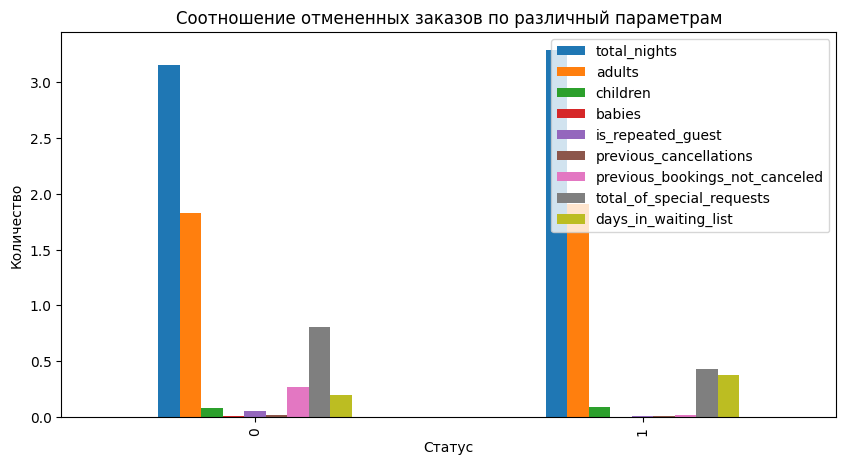

In [63]:
df.groupby('is_canceled')['total_nights', 'adults',
                          'children', 'babies',
                          'is_repeated_guest', 'previous_cancellations', 
                          'previous_bookings_not_canceled', 'total_of_special_requests',
                          'days_in_waiting_list',].mean()\
                        .plot(kind = 'bar', figsize = (10,5))
plt.title('Соотношение отмененных заказов по различный параметрам')
plt.xlabel("Статус")
plt.ylabel("Количество");

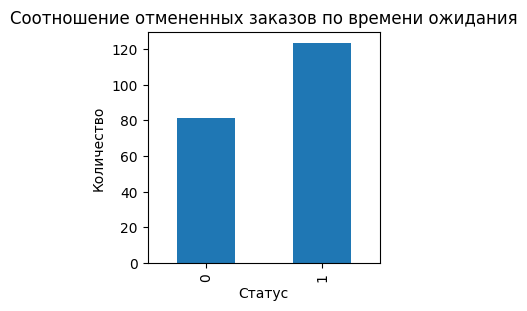

In [64]:
df.groupby('is_canceled')['lead_time'].mean()\
                        .plot(kind = 'bar', figsize = (3, 3))
plt.title('Соотношение отмененных заказов по времени ожидания')
plt.xlabel("Статус")
plt.ylabel("Количество");

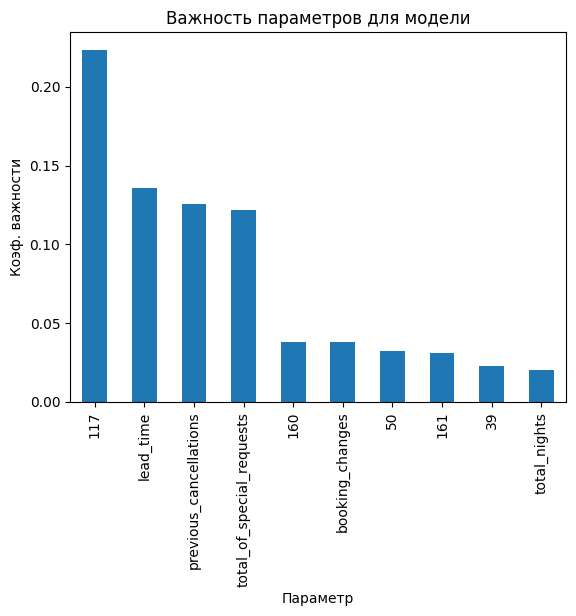

In [67]:
pd.Series(data = model.feature_importances_, index = features.columns).\
sort_values(ascending = False).head(10).plot(kind = 'bar')
plt.title('Важность параметров для модели')
plt.xlabel("Параметр")
plt.ylabel("Коэф. важности");

Для вычисления ненадежного клиента следует обратить внимание на следующее:
- Длительное время между датой бронирования и датой прибытия;
- Большое количество предыдущих отмен заказа;
- Малое количество специальных отметок.

### Шаг 6. Напишите общий вывод

Стоит применить систему депозитов. 

За 2017 система увеличила доход на 25%.